# Reddit & Quibi: Web API and NLP
## Part 5: Comparison w Quibi Data

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
import regex as re

For the last part of this project, it's time to make predictions on the Quibi show descriptions. By classifying them to fit these subreddits, the goal is to see which shows would appeal to consumers of these three mediums. I'll start by bringing in my best model and Count Vectorizer.

In [2]:
lr = pickle.load(open('../model/log_reg_1.pkl', 'rb'))
cvec = pickle.load(open('../model/cvec_1.pkl', 'rb'))

Next, I'll load in the Quibi data, do some light cleaning with RegEx, and combine the title, genre, and description into one column.

In [3]:
quibi = pd.read_csv('../datasets/quibi_raw.csv')

In [4]:
quibi['text'] = quibi['title'] + ' ' + quibi['genre'] + ' ' + quibi['description']

In [5]:
quibi['text'] = quibi['text'].apply(lambda x: re.sub('\\n', ' ', x))

In [6]:
quibi['text'] = quibi['text'].apply(lambda x: re.sub('\\r', ' ', x))

This combined column will be what the model makes predictions on:

In [7]:
X = quibi['text']

Before making predictions, I'll need to transform the data with the same Count Vectorizer fit to the Reddit data.

In [8]:
X_c = cvec.transform(X)

Now, I'll generate the predictions. I also want to draw out the probabilities from the predictions to take a closer look at how the model is working.

In [9]:
pred = lr.predict(X_c)

In [10]:
prob = lr.predict_proba(X_c)

Saving these probabilities in a new DataFrame, then adding it to the Quibi DataFrame:

In [11]:
prob_df = pd.DataFrame(prob)

In [12]:
prob_df.rename(columns={0 : 'Podcast', 1 : 'TV', 2: 'Video'}, inplace=True)

In [13]:
quibi['prediction'] = pred

In [14]:
quibi = pd.concat([quibi, prob_df], axis=1)

Below is the overall breakdown for how many shows were classified for each platform.

In [15]:
quibi['prediction'].value_counts()

1    22
0    19
2    12
Name: prediction, dtype: int64

Here are the top shows for Podcasts:

In [16]:
quibi.sort_values('Podcast', ascending=False).head()

,title,genre,description,cast_crew,rating,season,release,url,text,prediction,Podcast,TV,Video
40,Sports AM by TSN,"Sports, News","Hosted by Lindsay Hamilton and Kayla Grey, Spo...","['Lindsay Hamilton', 'Kayla Grey']",NaN,1 season,Released,https://quibi.com/shows/sports-am-by-tsn-610,"Sports AM by TSN Sports, News Hosted by Lindsa...",0,0.998286,0.001599,0.000115
39,Speedrun by Polygon,"Gaming, News",Speedrun is your daily dose of the latest gami...,['Jimmy Mondal'],NaN,1 season,Spring 2020,https://quibi.com/shows/speedrun-by-polygon-574,"Speedrun by Polygon Gaming, News Speedrun is y...",0,0.996313,0.003504,0.000184
30,POP5,"News, Music","POP5, by iHeartRadio, is a daily, fast-paced, ...",['Tim Kash'],NaN,1 season,Spring 2020,https://quibi.com/shows/pop-5-614,"POP5 News, Music POP5, by iHeartRadio, is a da...",0,0.990383,0.009608,0.000009
13,For the Cultura by Telemundo,LatinX Entertainment News,For the Cultura by Telemundo looks beyond the ...,['Alfredo Lomeli'],NaN,1 season,Spring 2020,https://quibi.com/shows/for-the-cultura-by-tel...,For the Cultura by Telemundo LatinX Entertainm...,0,0.970835,0.028285,0.000880
32,Pulso News by Telemundo,News,Pulso News by Telemundo is a daily newscast ca...,['Andrea Martinez'],NaN,1 season,Spring 2020,https://quibi.com/shows/pulso-news-by-telemund...,Pulso News by Telemundo News Pulso News by Tel...,0,0.966317,0.031315,0.002368


Here are the top shows for TV:

In [17]:
quibi.sort_values('TV', ascending=False).head(5)

,title,genre,description,cast_crew,rating,season,release,url,text,prediction,Podcast,TV,Video
23,Most Dangerous Game,"Action-Packed, Thriller",A man (Liam Hemsworth) desperate and in debt. ...,"['Liam Hemsworth', 'Christoph Waltz', 'Sarah G...",TV-MA,1 season,Released,https://quibi.com/shows/most-dangerous-game-566,"Most Dangerous Game Action-Packed, Thriller A ...",1,0.000256,0.999023,0.000722
31,Prodigy,"Sports, Documentary",Each episode of this docu-series profiles a yo...,"['Megan Rapinoe', 'Jalen Green', 'Chantel Nava...",NaN,1 season,Released,https://quibi.com/shows/prodigy-520,"Prodigy Sports, Documentary Each episode of th...",1,0.000615,0.998882,0.000503
7,Dishmantled,Cooking Competition,Take two blindfolded chef contestants. Blast a...,"['Tituss Burgess', 'Antoni Porowski', 'Rachel ...",NaN,1 season,Released,https://quibi.com/shows/dishmantled-504,Dishmantled Cooking Competition Take two blind...,1,0.000108,0.997127,0.002765
33,Punk'd,"Prank, Celebrity",Punk'd is back! And no one is safe! The iconic...,"['Chance the Rapper', 'Megan Thee Stallion', '...",NaN,1 season,Released,https://quibi.com/shows/punkd-529,"Punk'd Prank, Celebrity Punk'd is back! And no...",1,0.000025,0.996316,0.003659
26,NewsDay by CTV,News,Canada’s #1 news network presents two shows de...,[],NaN,1 season,Released,https://quibi.com/shows/newsday-by-ctv-578,NewsDay by CTV News Canada’s #1 news network p...,1,0.001766,0.995202,0.003032


Here are the top shows for Video:

In [18]:
quibi.sort_values('Video', ascending=False).head()

,title,genre,description,cast_crew,rating,season,release,url,text,prediction,Podcast,TV,Video
48,The Sauce,"Competition, Dance",Who’s the best dance crew in the country? Vira...,"['Ayleo ""Ayo"" Bowles', 'Mateo ""Teo"" Bowles', '...",TV-MA,1 season,Released,https://quibi.com/shows/the-sauce-555,"The Sauce Competition, Dance Who’s the best da...",2,0.000001,0.000150,0.999849
50,Weather Today by The Weather Channel,"Weather, News",Weather Today brings you a daily dose of weath...,[],NaN,1 season,Spring 2020,https://quibi.com/shows/weather-today-by-the-w...,"Weather Today by The Weather Channel Weather, ...",2,0.001574,0.009740,0.988686
1,Agua Donkeys,"Deadpan, Buddy, Comedy","What's standing between MP, Jer, and the one t...","['MP Cunningham', 'Jer Jackson', 'Baby Darring...",TV-MA,1 season,Released,https://quibi.com/shows/agua-donkeys-479,"Agua Donkeys Deadpan, Buddy, Comedy What's sta...",2,0.003085,0.034327,0.962588
11,Fight Like a Girl,"Inspirational, Reality",Ten women. Paired with WWE Superstars. Togethe...,"['Stephanie McMahon', 'Alexa Bliss', 'Sasha Ba...",NaN,1 season,Released,https://quibi.com/shows/fight-like-a-girl-589,"Fight Like a Girl Inspirational, Reality Ten w...",2,0.048479,0.070773,0.880749
41,Survive,"Tense, Drama",Jane wants to end it all. Then a plane crash a...,"['Sophie Turner', 'Corey Hawkins']",TV-MA,1 season,Released,https://quibi.com/shows/survive-526,"Survive Tense, Drama Jane wants to end it all....",2,0.000436,0.194829,0.804736


For demonstrative purposes, I want to be able to show what words in the text were the strongest indicator of a class. To do this, I'm going to create a DataFrame of the terms and coefficients:

In [19]:
coef_df = pd.DataFrame(lr.coef_).T

In [20]:
features_cvec = cvec.get_feature_names()
coef_df['term'] = features_cvec

In [21]:
coef_df.shape

(60000, 4)

In [22]:
def keywords(media, row):
    search_list = set(coef_df.sort_values(media, ascending=False)['term'][:6000])
    example = quibi.loc[row, 'text']
    example = example.split(' ')
    keywords = []
    for i in example:
        if i in search_list:
            keywords.append(i)
    return keywords

The words returned in the keyword function are terms with the highest coeefficients (top 1000) for their media. I'm also including the full text for context.

In [23]:
#Podcast: Speedrun by Polygun
keywords(0, 39)

['daily', 'gaming', 'entertainment', 'culture', 'expert', 'best', 'gaming']

In [24]:
quibi.loc[39, 'text']

'Speedrun by Polygon Gaming, News Speedrun is your daily dose of the latest gaming and entertainment culture news. Packed with expert analysis from the Polygon team, exclusives, recommendations, and more, host Jimmy Mondal celebrates the best of the gaming community.'

In [25]:
#TV: Most Dangerous Game
keywords(1, 23)

['thriller', 'hunter', 'turns']

In [26]:
quibi.loc[23, 'text']

'Most Dangerous Game Action-Packed, Thriller A man (Liam Hemsworth) desperate and in debt. In a dystopian thriller where the hunter turns out to be the hunted. Game on.     New episodes every weekday.'

In [27]:
#Video: The Sauce Competition
keywords(2, 48)

['dance', 'dance', 'travel', 'teams']

In [28]:
quibi.loc[48, 'text']

'The Sauce Competition, Dance Who’s the best dance crew in the country? Viral dance sensations Ayo & Teo travel across America as teams battle head-to-head for a chance to take home $25,000.    All episodes streaming now.'

Finally, to help understand how the model is working, I'm going to create plots for the top 10 words of each subreddits with that word's coefficient for that media.

In [29]:
coef_df.sort_values(0, ascending=False)[['term', 0]][:10]

,term,0
30184,listen,2.650807
12415,daily 2019,2.418407
42188,recommendations,2.101106
42086,recommend,1.950586
49919,suggestions,1.935066
46933,similar,1.914889
39565,preferably,1.864037
40175,promote,1.840060
34163,mt,1.825441
30462,literature,1.817715


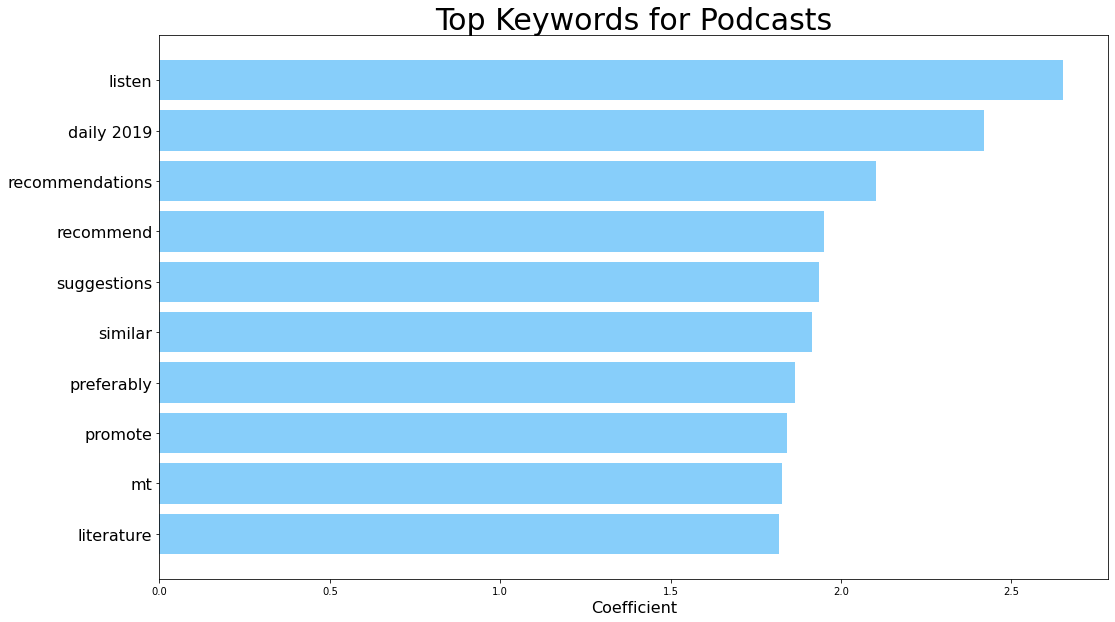

In [30]:
plt.figure(figsize = (17, 10))
pod_x = list(coef_df.sort_values(0, ascending=False)[['term', 0]][:10]['term'])
pod_y = list(coef_df.sort_values(0, ascending=False)[['term', 0]][:10][0])
plt.barh(pod_x, pod_y, color = 'lightskyblue')
#Help inverting the axis from https://github.com/plotly/plotly.github.io/issues/110
plt.gca().invert_yaxis()
plt.title('Top Keywords for Podcasts', size = 30)
plt.xlabel('Coefficient', size = 16)
plt.yticks(size=16)

plt.savefig('../plots/top_podcasts.png', dpi=235)

In [31]:
coef_df.sort_values(1, ascending=False)[['term', 1]][:20]

,term,1
13387,despicable,2.369771
5523,best friend,2.306846
13000,deceived,2.255883
2581,adolescence,2.101693
23901,homestay,2.061170
33076,midnight delivery,1.927370
48303,spoilers,1.910832
38524,plot,1.890761
7192,brooklyn,1.861668
50323,surrender,1.836296


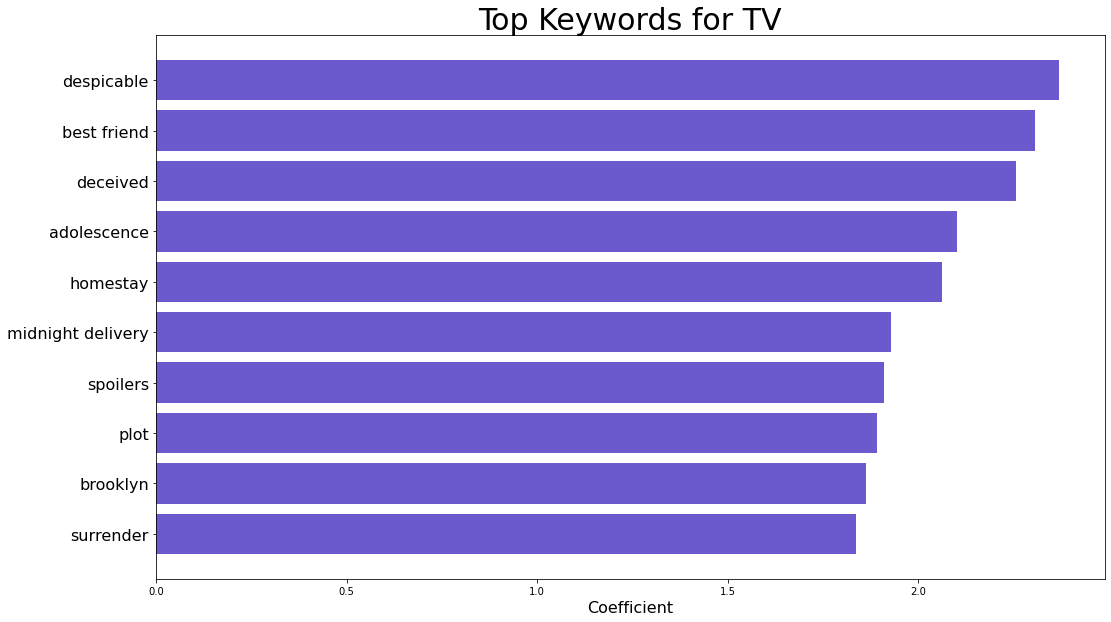

In [32]:
plt.figure(figsize = (17, 10))
tv_x = list(coef_df.sort_values(1, ascending=False)[['term', 1]][:10]['term'])
tv_y = list(coef_df.sort_values(1, ascending=False)[['term', 1]][:10][1])
plt.barh(tv_x, tv_y, color = 'slateblue')

plt.gca().invert_yaxis()
plt.title('Top Keywords for TV', size = 30)
plt.xlabel('Coefficient', size = 16)
plt.yticks(size=16)

plt.savefig('../plots/top_tv.png', dpi=235)

In [33]:
coef_df.sort_values(2, ascending=False)[['term', 2]][:10]

,term,2
30625,lockdown,1.656984
19516,fresh daily,1.638992
9763,cod,1.603050
56653,walkthrough,1.551676
120,04,1.425858
43691,roblox,1.411465
35374,oc,1.404181
18953,fish,1.383764
42920,remedies,1.363637
22561,haircut,1.358239


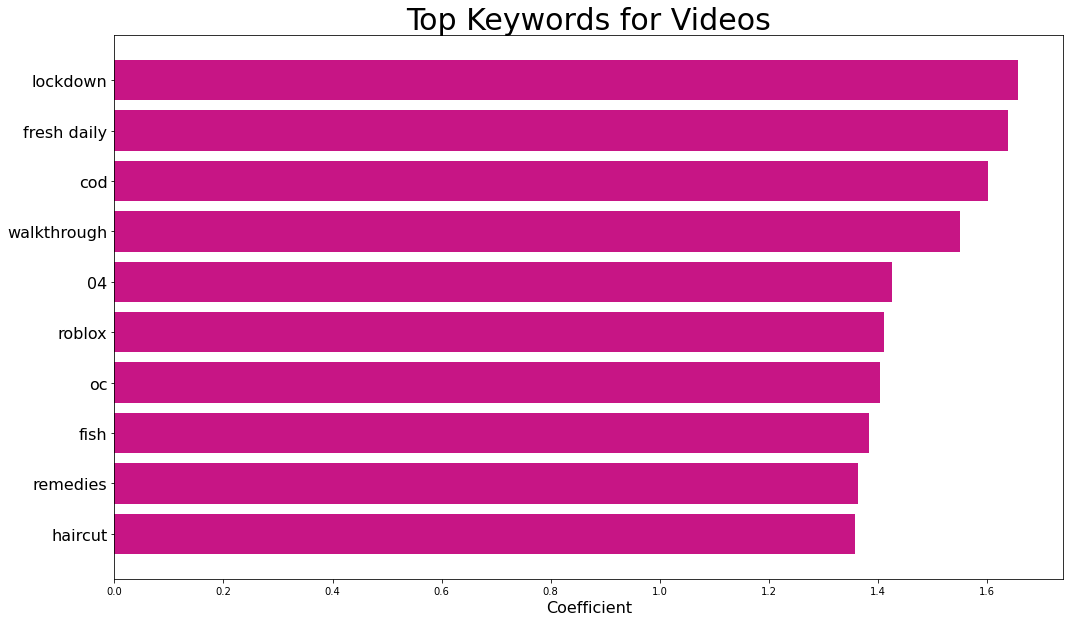

In [34]:
plt.figure(figsize = (17, 10))
vid_x = list(coef_df.sort_values(2, ascending=False)[['term', 2]][:10]['term'])
vid_y = list(coef_df.sort_values(2, ascending=False)[['term', 2]][:10][2])
plt.barh(vid_x, vid_y, color = 'mediumvioletred')

plt.gca().invert_yaxis()
plt.title('Top Keywords for Videos', size = 30)
plt.xlabel('Coefficient', size = 16)
plt.yticks(size=16)

plt.savefig('../plots/top_videos.png', dpi=235)